In [1]:
import torch
import numpy as np

In [2]:
import pandas as pd
from PIL import Image

path="C:/Users/Administrator/program/data/"
data = pd.read_csv(path+"train.csv") 
file=np.array(data["file"])
source=np.array(data["source"])
p_type=np.array(data["type"])

n1=data.shape[0]
size=320
p_array=np.empty((n1,size,size,3))

for i in range(n1) :
        path_img=path+source[i]+file[i]
        image_i=np.array(Image.open(path_img).convert("RGB").resize((size,size)))
        p_array[i]=image_i

p_array=torch.tensor(p_array).permute(0,3,1,2).float()

p_type[p_type=="nature"]=0
p_type[p_type=="board"]=1
p_type[p_type=="paper"]=2
p_type[p_type=="file"]=2
#由于本实验没有设置其它类型，打标签时也没有打其他标签所以无其他值处理
p_type=torch.tensor(p_type.astype(int))

In [3]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2) #torch.Size([233, 8, 158, 158])
        self.pool1 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 8, 79, 79])
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1)   #torch.Size([233, 16, 75, 75])
        self.pool2 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 16, 37, 37])
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1)   #torch.Size([233, 32, 33, 33])
        self.pool3 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 32, 16, 16])
        self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=50, kernel_size=5, stride=1)   #torch.Size([233, 50, 12, 12])
        self.pool4 = torch.nn.MaxPool2d((2,2), stride=2)   #torch.Size([233, 50, 6, 6])
        self.fc1 = torch.nn.Linear(in_features=1800,out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100,out_features=3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        x = self.fc1(x.view(-1, 1800))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.softmax(x,dim=1)
        return x

In [4]:
nepoch=1000
model=MyModel()
learning_rate = 0.005

temp_path='C:/Users/Administrator/program/TempModel/'

lossfn = torch.nn.NLLLoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

LostList=[]

for i in range(nepoch): 
    pred= model(p_array)
    loss = lossfn(torch.log(pred),p_type.long())
    LostList.append(loss.detach().numpy())
        
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i % 10 == 9 :
        print("epoch=",i+1,", loss=",loss)
        TempFileName="temp"+str(i)+".pth"
        torch.save(model.state_dict(),temp_path+TempFileName)

epoch= 10 , loss= tensor(1.0596, grad_fn=<NllLossBackward0>)
epoch= 20 , loss= tensor(0.9694, grad_fn=<NllLossBackward0>)
epoch= 30 , loss= tensor(0.8456, grad_fn=<NllLossBackward0>)
epoch= 40 , loss= tensor(0.7848, grad_fn=<NllLossBackward0>)
epoch= 50 , loss= tensor(0.7646, grad_fn=<NllLossBackward0>)
epoch= 60 , loss= tensor(0.7983, grad_fn=<NllLossBackward0>)
epoch= 70 , loss= tensor(0.7425, grad_fn=<NllLossBackward0>)
epoch= 80 , loss= tensor(0.7284, grad_fn=<NllLossBackward0>)
epoch= 90 , loss= tensor(0.7075, grad_fn=<NllLossBackward0>)
epoch= 100 , loss= tensor(0.7157, grad_fn=<NllLossBackward0>)
epoch= 110 , loss= tensor(0.6952, grad_fn=<NllLossBackward0>)
epoch= 120 , loss= tensor(0.6902, grad_fn=<NllLossBackward0>)
epoch= 130 , loss= tensor(0.6739, grad_fn=<NllLossBackward0>)
epoch= 140 , loss= tensor(0.6657, grad_fn=<NllLossBackward0>)
epoch= 150 , loss= tensor(0.6560, grad_fn=<NllLossBackward0>)
epoch= 160 , loss= tensor(0.6354, grad_fn=<NllLossBackward0>)
epoch= 170 , loss

In [5]:
PATH='C:/Users/Administrator/program/model.pth'
torch.save(model.state_dict(),PATH)


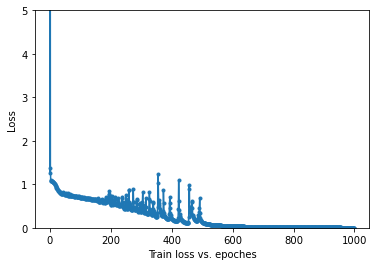

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

x = range(0, 1000)
y = LostList

plt.plot(x, y, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylim(0,5)
plt.ylabel('Loss')
plt.show()
plt.savefig("C:/Users/Administrator/program/accuracy_loss.jpg")


In [7]:
#混淆矩阵
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[int(p), int(t)] += 1
    return conf_matrix

#训练集上的混淆矩阵的效果
y_pred=torch.argmax(model(p_array),dim=1)
print("训练集混淆矩阵：")
conf_matrix=pd.DataFrame(confusion_matrix(y_pred, p_type, np.zeros((3,3))))
conf_matrix.columns = ['nature_true','board_true','file&paper_true']
conf_matrix.index = ['nature_pred','board_pred','file&paper_pred']
print(conf_matrix)

训练集混淆矩阵：
                 nature_true  board_true  file&paper_true
nature_pred            135.0         0.0              0.0
board_pred               0.0       202.0              0.0
file&paper_pred          0.0         1.0            160.0
